In [1]:
"""
General GridWorld Environment
"""
import math
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import time
import matplotlib.pyplot as plt

class Grid(object):
    def __init__(self, x:int = None,
                       y:int = None,
                       type:int = 0,
                       reward:float = 0.0,
                       value:float = 0.0):  # value属性备用
        self.x = x                          # 坐标x
        self.y = y
        self.type = type                    # 类别值（0：空；1：障碍或边界）
        self.reward = reward                # 该格子的即时奖励
        self.name = None                    # 该格子的名称
        self._update_name()

    def _update_name(self):
        self.name = "X{0}-Y{1}".format(self.x, self.y)

    def __str__(self):
        return "name:{4}, x:{0}, y:{1}, type:{2}".format(self.x,
                                                                    self.y,
                                                                    self.type,
                                                                    self.name
                                                                    )


class GridMatrix(object):
    '''格子矩阵，通过不同的设置，模拟不同的格子世界环境
    '''
    def __init__(self, n_width:int,                 # 水平方向格子数
                       n_height:int,                # 竖直方向格子数
                       default_type:int = 0,        # 默认类型
                       default_reward:float = 0.0,  # 默认即时奖励值
                       ):
        self.grids = None
        self.n_height = n_height
        self.n_width = n_width
        self.len = n_width * n_height
        self.default_reward = default_reward
        self.default_type = default_type
        self.reset()

    def reset(self):
        self.grids = []
        for x in range(self.n_height):
            for y in range(self.n_width):
                self.grids.append(Grid(x,
                                       y,
                                       self.default_type,
                                       self.default_reward
                                       ))

    def get_grid(self, x, y=None):
        '''获取一个格子信息
        args:坐标信息，由x，y表示或仅有一个类型为tuple的x表示
        return:grid object
        '''
        xx, yy = None, None
        if isinstance(x, int):
            xx, yy = x, y
        elif isinstance(x, tuple):
            xx, yy = x[0], x[1]
        assert(xx >= 0 and yy >= 0 and xx < self.n_width and yy < self.n_height), "任意坐标值应在合理区间"
        index = yy * self.n_width + xx
        return self.grids[index]

    def set_reward(self, x, y, reward):
        grid = self.get_grid(x, y)
        if grid is not None:
            grid.reward = reward
        else:
            raise("grid doesn't exist")

    def set_value(self, x, y, value):
        grid = self.get_grid(x, y)
        if grid is not None:
            grid.value = value
        else:
            raise("grid doesn't exist")

    def set_type(self, x, y, type):
        grid = self.get_grid(x, y)
        if grid is not None:
            grid.type = type
        else:
            raise("grid doesn't exist")

    def get_reward(self, x, y):
        grid = self.get_grid(x, y)
        if grid is None:
            return None
        return grid.reward

    def get_value(self, x, y):
        grid = self.get_grid(x, y)
        if grid is None:
            return None
        return grid.value

    def get_type(self, x, y):
        grid = self.get_grid(x, y)
        if grid is None:
            return None
        return grid.type


class GridWorldEnv(gym.Env):
    '''格子世界环境，可以模拟各种不同的格子世界
    '''
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 30
    }

    def __init__(self, n_width: int=10,
                       n_height: int = 7,
                       u_size=40,
                       default_reward: float = 0,
                       default_type=0,
                    ):
        self.u_size = u_size                        # 当前格子绘制尺寸
        self.n_width = n_width                      # 格子世界宽度（以格子数计）
        self.n_height = n_height                    # 高度
        self.width = u_size * n_width               # 场景宽度 screen width
        self.height = u_size * n_height             # 场景长度
        self.default_reward = default_reward
        self.default_type = default_type

        self.grids = GridMatrix(n_width=self.n_width,
                                n_height=self.n_height,
                                default_reward=self.default_reward,
                                default_type=self.default_type,
                                )
        self.reward = 0                             # for rendering
        self.action = None                          # for rendering

        # 0,1,2,3 represent left, right, up, down
        self.action_space = spaces.Discrete(4)
        # 观察空间由low和high决定
        self.observation_space = spaces.Discrete(self.n_height * self.n_width)
        # 坐标原点为左下角，这个pyglet是一致的
        # 通过设置起始点、终止点以及特殊奖励和类型的格子可以构建各种不同类型的格子世界环境
        self.ends = [(7, 3)]                        # 终止格子坐标，可以有多个
        self.start = (0, 3)                         # 起始格子坐标，只有一个
        self.types = []                             # 特殊种类的格子在此设置。[(3,2,1)]表示(3,2)处值为1
        self.rewards = []                           # 特殊奖励的格子在此设置，终止格子奖励0
        self.refresh_setting()
        self.viewer = None                          # 图形接口对象
        self.seed()                                 # 产生一个随机子
        self.reset()


    def seed(self, seed=None):
        # 产生一个随机化时需要的种子，同时返回一个np_random对象，支持后续的随机化生成操作
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        self.action = action                        # action for rendering
        old_x, old_y = self._state_to_xy(self.state)
        new_x, new_y = old_x, old_y


        if action == 0: new_x -= 1  # left
        elif action == 1: new_x += 1  # right
        elif action == 2: new_y += 1  # up
        elif action == 3: new_y -= 1  # down
        # boundary effect
        if new_x < 0: new_x = 0
        if new_x >= self.n_width: new_x = self.n_width - 1
        if new_y < 0: new_y = 0
        if new_y >= self.n_height: new_y = self.n_height - 1

        # wall effect:
        # 类型为1的格子为障碍格子，不可进入
        if self.grids.get_type(new_x, new_y) == 1:
            new_x, new_y = old_x, old_y

        self.reward = self.grids.get_reward(new_x, new_y)
        done = self._is_end_state(new_x, new_y)
        self.state = self._xy_to_state(new_x, new_y)
        # 提供格子世界所有的信息在info内
        info = {"x": new_x, "y": new_y, "grids": self.grids}
        return self.state, self.reward, done, info

    # 将状态变为横纵坐标
    def _state_to_xy(self, s):
        x = s % self.n_width
        y = int((s - x) / self.n_width)
        return x, y

    def _xy_to_state(self, x, y=None):
        if isinstance(x, int):
            assert (isinstance(y, int)), "incomplete Position info"
            return x + self.n_width * y
        elif isinstance(x, tuple):
            return x[0] + self.n_width * x[1]
        return -1  # 未知状态

    def refresh_setting(self):
        '''用户在使用该类创建格子世界后可能会修改格子世界某些格子类型或奖励值
        的设置，修改设置后通过调用该方法使得设置生效。
        '''
        for x, y, r in self.rewards:
            self.grids.set_reward(x, y, r)
        for x, y, t in self.types:
            self.grids.set_type(x, y, t)

    def reset(self):
        self.state = self._xy_to_state(self.start)
        return self.state

    # 判断是否是终止状态
    def _is_end_state(self, x, y=None):
        if y is not None:
            xx, yy = x, y
        elif isinstance(x, int):
            xx, yy = self._state_to_xy(x)
        else:
            assert (isinstance(x, tuple)), "坐标数据不完整"
            xx, yy = x[0], x[1]
        for end in self.ends:
            if xx == end[0] and yy == end[1]:
                return True
        return False

    # 图形化界面
    def render(self, mode='human', close=False):
        if close:
            if self.viewer is not None:
                self.viewer.close()
                self.viewer = None
            return
        zero = (0, 0)
        u_size = self.u_size
        m = 2                                       # 格子之间的间隙尺寸

        # 如果还没有设定屏幕对象，则初始化整个屏幕具备的元素。
        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(self.width, self.height)
            # 绘制格子
            for x in range(self.n_width):
                for y in range(self.n_height):
                    v = [(x * u_size + m, y * u_size + m),
                         ((x + 1) * u_size - m, y * u_size + m),
                         ((x + 1) * u_size - m, (y + 1) * u_size - m),
                         (x * u_size + m, (y + 1) * u_size - m)]

                    rect = rendering.FilledPolygon(v)
                    r = self.grids.get_reward(x, y) / 10
                    if r < 0:
                        rect.set_color(0.9 - r, 0.9 + r, 0.9 + r)
                    elif r > 0:
                        rect.set_color(0.3, 0.5 + r, 0.3)
                    else:
                        rect.set_color(0.9, 0.9, 0.9)
                    self.viewer.add_geom(rect)
                    # 绘制边框
                    v_outline = [(x * u_size + m, y * u_size + m),
                                 ((x + 1) * u_size - m, y * u_size + m),
                                 ((x + 1) * u_size - m, (y + 1) * u_size - m),
                                 (x * u_size + m, (y + 1) * u_size - m)]
                    outline = rendering.make_polygon(v_outline, False)
                    outline.set_linewidth(3)

                    if self._is_end_state(x, y):
                        # 给终点方格添加金黄色边框
                        outline.set_color(0.9, 0.9, 0)
                        self.viewer.add_geom(outline)
                    if self.start[0] == x and self.start[1] == y:
                        outline.set_color(0.5, 0.5, 0.8)
                        self.viewer.add_geom(outline)
                    if self.grids.get_type(x, y) == 1:  # 障碍格子用深灰色表示
                        rect.set_color(0.3, 0.3, 0.3)
                    else:
                        pass
            # 绘制个体
            self.agent = rendering.make_circle(u_size / 4, 30, True)
            self.agent.set_color(1.0, 1.0, 0.0)
            self.viewer.add_geom(self.agent)
            self.agent_trans = rendering.Transform()
            self.agent.add_attr(self.agent_trans)

            # 更新个体位置
        x, y = self._state_to_xy(self.state)
        self.agent_trans.set_translation((x + 0.5) * u_size, (y + 0.5) * u_size)

        return self.viewer.render(return_rgb_array= mode == 'rgb_array')


def CleanRobot():
    '''
        扫地机器人格子世界环境
    '''
    env = GridWorldEnv(n_width=5,
                       n_height = 5,
                       u_size = 60,
                       default_reward = -1,
                       default_type = 0,
                    )
    env.action_space = spaces.Discrete(4) # left or right
    env.start = (0,0)
    env.ends = [(4,0),(2,4),(1,3),(3,2)]
    env.rewards.append((2,4,5))
    env.rewards.append((4,0,1))
    env.rewards.append((1,3,-100))
    env.rewards.append((3,2,-100))
    env.refresh_setting()
    return env


In [2]:
env=CleanRobot()

In [3]:
render=False
running_reward=None
np.random.seed(2)
epsilon=0.9
Q_q_learning=np.zeros([env.observation_space.n,env.action_space.n])
Q_SARSA=np.zeros([env.observation_space.n,env.action_space.n])
lr=.6
lamda=.95
num_episodes=1000
max_steps=30
REWARD_q_learning=[]
REWARD_SARSA=[]

In [4]:
def Q_learning():
    for i in range(num_episodes):
        episode_time=time.time()
        s=env.reset()
        reward=0
        for j in range(99):
            if render: env.render()
            if (np.random.uniform()>epsilon) or (Q_q_learning[s,:].all()==0):
                a=np.random.randint(4)
            else:
                a=np.argmax(Q_q_learning[s,])
            s_, r, d, _ = env.step(a)
            Q_q_learning[s,a]=Q_q_learning[s,a]+(r+lamda*np.max(Q_q_learning[s_,:])-Q_q_learning[s,a])
            reward+=r
            s=s_
            if d==True:
                break
        REWARD_q_learning.append(reward)
    print(Q_q_learning)

In [5]:
Q_learning()

[[-1.62270273e+00 -6.55476563e-01 -6.55476563e-01 -1.62270273e+00]
 [-1.62270273e+00  3.62656250e-01  3.62656250e-01 -6.55476563e-01]
 [-6.55476563e-01 -5.00000000e-02  1.43437500e+00  3.62656250e-01]
 [ 3.62656250e-01  1.00000000e+00 -1.04750000e+00 -5.00000000e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.70987500e+00 -2.85250000e+00  3.62656250e-01 -1.62270273e+00]
 [-6.55476563e-01  1.43437500e+00 -1.95000000e+00 -6.55476563e-01]
 [ 3.62656250e-01 -1.04750000e+00  2.56250000e+00  3.62656250e-01]
 [-1.00000000e+00 -5.00000000e-02 -1.00000000e+02 -5.00000000e-02]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  1.00000000e+00]
 [-1.95000000e+00  1.43437500e+00  1.43437500e+00 -6.55476563e-01]
 [ 3.62656250e-01  2.56250000e+00 -1.00000000e+02  3.62656250e-01]
 [ 1.43437500e+00 -1.00000000e+02  3.75000000e+00  1.43437500e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+00 -1.00000000e+00 -5.00000000e

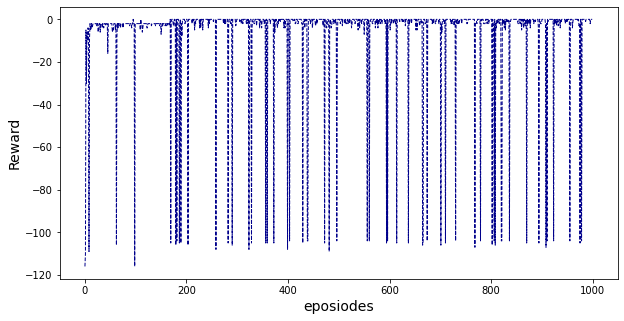

In [6]:
plt.figure(figsize=(10,5))
plt.xlabel(u'eposiodes',fontsize=14)
plt.ylabel(u'Reward',fontsize=14)

plt.plot(range(num_episodes),REWARD_q_learning,color='darkblue',linewidth=1,linestyle='--')

plt.show()

In [7]:
Q_learning()

[[-1.62270273e+00 -6.55476563e-01 -6.55476563e-01 -1.62270273e+00]
 [-1.62270273e+00  3.62656250e-01  3.62656250e-01 -6.55476563e-01]
 [-6.55476563e-01 -5.00000000e-02  1.43437500e+00  3.62656250e-01]
 [ 3.62656250e-01  1.00000000e+00 -1.04750000e+00 -5.00000000e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.70987500e+00  3.62656250e-01  3.62656250e-01 -1.62270273e+00]
 [-6.55476563e-01  1.43437500e+00  1.43437500e+00 -6.55476563e-01]
 [ 3.62656250e-01 -1.04750000e+00  2.56250000e+00  3.62656250e-01]
 [-1.00000000e+00 -5.00000000e-02 -1.00000000e+02 -5.00000000e-02]
 [-1.04750000e+00 -5.00000000e-02 -1.00000000e+00  1.00000000e+00]
 [ 3.62656250e-01  1.43437500e+00  1.43437500e+00 -6.55476563e-01]
 [ 3.62656250e-01  2.56250000e+00 -1.00000000e+02  3.62656250e-01]
 [ 1.43437500e+00 -1.00000000e+02  3.75000000e+00  1.43437500e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+00 -1.00000000e+00 -5.00000000e

In [8]:
def SARSA():
    for i in range(num_episodes):
        episode_time=time.time()
        s=env.reset()
        reward=0#本轮获得的reward
        for j in range(99):
            if render: env.render()
            if (np.random.uniform()>epsilon) or (Q_SARSA[s,:].all()==0):
                a=np.random.randint(4)
            else:
                a=np.argmax(Q_SARSA[s,:])
            s_, r, d, _ = env.step(a)
            a_=np.argmax(Q_SARSA[s_,:])
            Q_SARSA[s,a]=Q_SARSA[s,a]+(r+lamda*Q_SARSA[s_,a_]-Q_SARSA[s,a])
            reward+=r
            s=s_
            if d==True:
                break
        REWARD_SARSA.append(reward)
    print(Q_SARSA)

In [9]:
SARSA()

[[-1.62270273e+00 -1.99512500e+00 -6.55476563e-01 -1.62270273e+00]
 [-2.89536875e+00 -1.04750000e+00 -2.89536875e+00 -1.99512500e+00]
 [-1.99512500e+00 -5.00000000e-02 -1.99512500e+00 -1.04750000e+00]
 [-1.04750000e+00  1.00000000e+00 -1.04750000e+00 -5.00000000e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.55476563e-01 -2.89536875e+00  3.62656250e-01 -1.62270273e+00]
 [-2.85250000e+00 -1.99512500e+00 -2.85250000e+00 -1.99512500e+00]
 [-2.85250000e+00 -1.04750000e+00 -1.95000000e+00 -1.04750000e+00]
 [-1.99512500e+00 -1.00000000e+00 -1.00000000e+02 -5.00000000e-02]
 [-1.04750000e+00 -1.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 3.62656250e-01 -6.55476563e-01  1.43437500e+00 -6.55476563e-01]
 [ 3.62656250e-01 -1.95000000e+00 -1.00000000e+02 -2.89536875e+00]
 [-1.95000000e+00 -1.00000000e+02 -1.00000000e+00 -1.95000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e

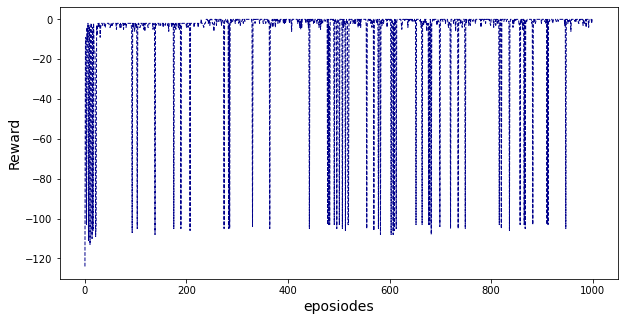

In [10]:
plt.figure(figsize=(10,5))
plt.xlabel(u'eposiodes',fontsize=14)
plt.ylabel(u'Reward',fontsize=14)

plt.plot(range(num_episodes),REWARD_SARSA,color='darkblue',linewidth=1,linestyle='--')

plt.show()